In [3]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt #show img
import random
from numba import njit,prange

# 灑Impulse Noise (Salt-and-Pepper) 雜訊 0:0~0.2 255:0.2~0.4 不灑雜訊:0.4~1.0
def noise(img,p0=0.2,p255=0.2+0.2):
	for i in range(len(img)):
		rand=random.random()
		if(rand>=0 and rand<=p0):
			img[i]=0
		elif(rand>p0 and rand<=p0+p255):
			img[i]=255
		else:
			# do nothing
			img[i]=img[i]
	return img

@njit
def padding(img,pad):
    padded_img = np.zeros((img.shape[0]+2*pad,img.shape[1]+2*pad)) # (H,W)
    padded_img[pad:-pad,pad:-pad] = img # 外圈0 中間是img
    return padded_img

# @njit加速運算 https://medium.com/jacky-life/%E9%AD%AF%E8%9B%87%E8%AE%8A%E8%9F%92%E8%9B%87%E8%A8%98-41e9c047e8e5
@njit(parallel=True)
def Adaptive_Median_Filter(img,s=3,sMax=7):
    # 只接受灰階 Single channel
    if len(img.shape) == 3:
        raise Exception ("Single channel gray image only")

    H,W = img.shape
    # stride=1 zero-padding=kernel size(即screen_size)//2 >> 讓output img 卷積後圖的寬高不要變不糊掉
    # 以screen_size max=7 去算補幾個0
    pad = sMax//2
    # zero padding
    img_padded = padding(img,pad)

    img_denoise = np.zeros(img_padded.shape)

    # 3~512+3
    for i in prange(pad,H+pad+1):
        for j in range(pad,W+pad+1):
            value = Level_A(img_padded,i,j,s,sMax)
            img_denoise[i,j] = value

    # 刪掉padding的像素
    return img_denoise[pad:-pad,pad:-pad] 

@njit
def Level_A(mask,x,y,s,sMax):
    # mask 從3*3開始 [2:4+1,2:4+1] 5*5[1:5+1,1:5+1] 7*7[0:6+1.0:6+1]
    window = mask[x-(s//2):x+(s//2)+1,y-(s//2):y+(s//2)+1]
    h,w = window.shape
    Zxy = window[h//2,w//2]
    Zmin = np.min(window)
    Zmed = np.median(window)
    Zmax = np.max(window)

    A1 = Zmed - Zmin
    A2 = Zmed - Zmax

    # Zmin < Zmed < Zmax
    if A1 > 0 and A2 < 0:
        # 保證 Zmed 不為0、255
        return Level_B(window, Zmin, Zmed, Zmax)
    # Zmed = Zmin or Zmed = Zmax (Zmed可能 = 0 or 255)
    else: 
        # mask(3*3 5*5 7*7)
        s += 2 
        # screen size < 7 >> repeat Level_A 繼續增大 mask_size 判斷是 0or25 5細節 還是雜訊
        if s <= sMax:
            return Level_A(mask,x,y,s,sMax)
        # window size 至 最大仍可能為 0 or 255 >> 大片0 or 255 細節，保留原值
        else:
             return Zxy

# 保證 Zmed 不為0、255
@njit
def Level_B(window, Zmin, Zmed, Zmax):
    h,w = window.shape

    Zxy = window[h//2,w//2]
    B1 = Zxy - Zmin
    B2 = Zxy - Zmax

    # Zmin < Zxy < Zmax (Zxy 不為 noise 直接輸出)
    if B1 > 0 and B2 < 0 :
        return Zxy
    # Zxy<= Zmin or Zxy>=Zmax (Zxy 為 noise ，輸出 Zmed 去雜訊 )
    else:
        return Zmed


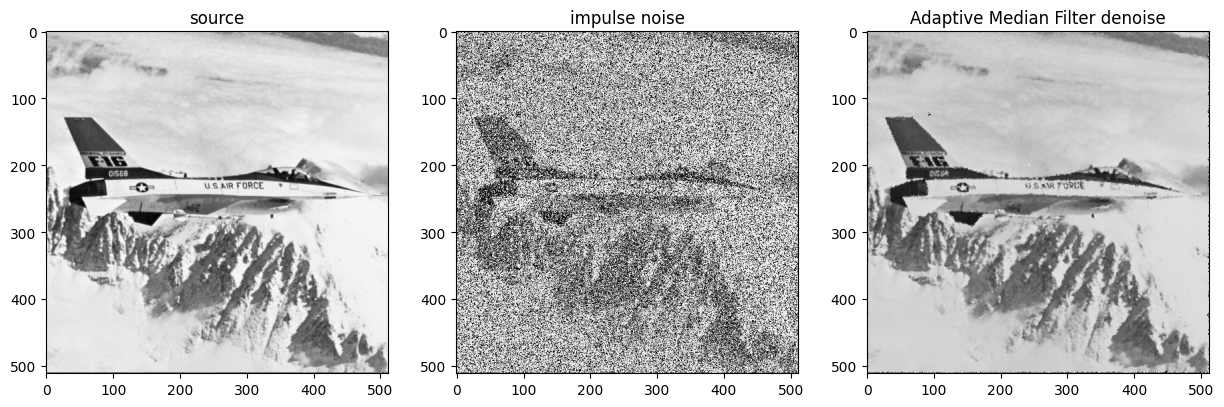

In [4]:
if __name__ == "__main__":
	img_path = "4.2.05.png"
	# 圖片轉灰階
	img_gray = cv2.imread(img_path ,cv2.IMREAD_GRAYSCALE)

	# 轉為一維
	img_noise=img_gray.copy()
	img_noise=img_noise.reshape(-1,)
	
	# 灑 impulse noise 雜訊
	img_noise=noise(img_noise,0.25,0.25)

	# 轉回二維
	img_noise=img_noise.reshape(img_gray.shape,)

	# Adaptive Median Filter 去雜訊 denoise
	img_denoise=Adaptive_Median_Filter(img_noise, s=3, sMax=7)
	
	# 印出圖片
	# 原始圖
	plt.figure(figsize=(15,15))
	plt.subplot(131)
	plt.title("source")
	plt.imshow(img_gray,cmap='gray')

	# 灑 impulse noise 圖
	plt.subplot(132)
	plt.title("impulse noise")
	plt.imshow(img_noise,cmap='gray')

	# Adaptive Median Filter 去雜訊 denoise 圖
	plt.subplot(133)
	plt.title("Adaptive Median Filter denoise")
	plt.imshow(img_denoise,cmap='gray')
	
	plt.show()
	cv2.imwrite("Adaptive_Median_Filter_denoise.png", img_denoise)